# Quick start

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from trufl.utils import gridder
from trufl.sampler import Sampler
from trufl.collector import DataCollector
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, CountCB, MoranICB, PriorCB)
from trufl.optimizer import Optimizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
red, black = '#BF360C', '#263238'

### Create a vector grid from a given raster

In [ ]:
fname_raster = '../files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

In [ ]:
gdf_grid.head()

,geometry
loc_id,
0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


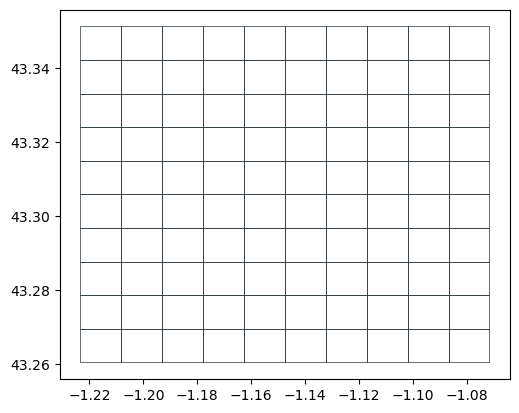

In [ ]:
gdf_grid.boundary.plot(color=black, lw=0.5);

### Random sampling in areas of interest

Generating a random set of points within a given:
- a geodataframe of polygons of interest (in this example just a grid with `loc_id`s);
- For each subarea (`loc_id`), we specify the number of measurements to be taken, which we simulate here by generating random numbers.

                                                 geometry
loc_id                                                   
0       MULTIPOINT ((-1.22301 43.26839), (-1.21877 43....
1       MULTIPOINT ((-1.22306 43.27011), (-1.22306 43....
2       MULTIPOINT ((-1.22324 43.28483), (-1.22307 43....
3       MULTIPOINT ((-1.22260 43.29145), (-1.21834 43....
4       MULTIPOINT ((-1.22118 43.30030), (-1.21881 43....


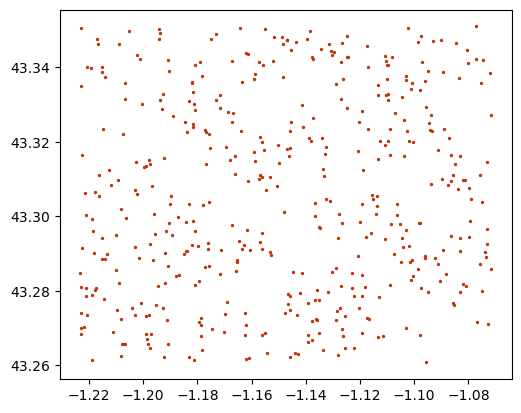

In [ ]:
sampler = Sampler(gdf_grid)
n = np.random.randint(0, high=10, size=len(gdf_grid), dtype=int)
sample_locs = sampler.sample(n, method='uniform')

print(sample_locs.head())
sample_locs.plot(markersize=2, color=red);

### Emulating data collection

With random sampling location defined, data collector should be to the field to take measurements. In our case, we "emulate" this process by "extracting" measurements from provided raster file.

We will emulate data collection from the raster shown below:

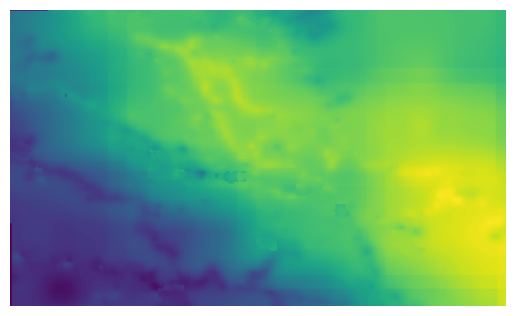

In [ ]:
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

"Measuring" variable of interest from a given raster:

                         geometry     value
loc_id                                     
0       POINT (-1.22301 43.26839)  0.000000
0       POINT (-1.21877 43.26155)  0.140682
0       POINT (-1.21098 43.26899)  0.087576
1       POINT (-1.22306 43.27011)  0.000000
1       POINT (-1.22306 43.27413)  0.000000


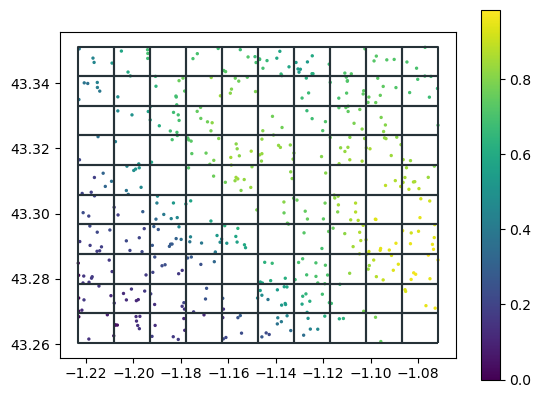

In [ ]:
dc_emulator = DataCollector(fname_raster)
samples_t0 = dc_emulator.collect(sample_locs)

print(samples_t0.head())
ax = samples_t0.plot(column='value', s=2, legend=True)
gdf_grid.boundary.plot(color=black, ax=ax);

### Getting current state

In [ ]:
state = State(samples_t0, gdf_grid, cbs=[
    MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5), PriorCB(fname_raster)
])

# You have to call the instance
state_t0 = state(); state_t0

,Max,Min,Standard Deviation,Count,Moran.I,Prior
loc_id,,,,,,
0,0.140682,0.000000,0.058005,3.0,NaN,0.102492
1,0.162192,0.000000,0.067804,6.0,0.519865,0.125727
2,0.169505,0.000000,0.067194,9.0,0.721950,0.161802
3,0.222695,0.167921,0.018633,8.0,0.232869,0.184432
4,0.233276,0.200708,0.014374,3.0,NaN,0.201405
...,...,...,...,...,...,...
95,0.887474,0.797440,0.025528,9.0,0.509964,0.803670
96,0.840809,0.830832,0.004988,2.0,NaN,0.763408
97,0.704799,0.704799,0.000000,1.0,NaN,0.727797


## Build the ranking of polygons based on several criteria

### Criteria
- MaxCB()
- MinCB()
- StdCB()
- CountCB()
- MoranICB(k=5) -- Gives 2 values (value , p-value)
- PriorCB

### Criteria type 
- Benefit (high values --> high score --> rank high --> prioritized sampling needed)
- Cost (high values --> low score --> low high --> Less sampling needed)

- MaxCB() -- Benefit
- MinCB() -- ???
- StdCB() -- Benefit
- CountCB() -- Cost (Low count -- higher priority because more samples need)
- MoranICB(k=5) -- Cost (high value -- highly correlated -- less need for sampling ?? )
- PriorCB -- Benefit

### MCDM techniques
- CP -- low values -- good alternative
- TOPSIS -- High Value -- good alternative

! Everything is converted to rank to account for these differences ! 


In [ ]:
# optimizer = Optimizer(state=state())
# optimizer.rank(...) -> dataframe with loc_id as index + ranking column

In [ ]:
# Todo Loc_id 0 gives a Nan result (verify, how to fix)
# Todo MoranI take into account 2 values (verify, how to fix)

state = State(gdf_samples_t0, [StdCB(), CountCB(), PriorCB(gdf_grid, fname_raster)])
optimizer = Optimizer(state=state)
matrix = optimizer.build_matrix(polygon_list = gdf_samples_t0.loc_id.unique())
matrix = optimizer.process_matrix(matrix, benefit_criteria)

ranking = optimizer.rank(
        x_matrix = matrix,
        alt_names=None,
        is_benefit_x=benefit_criteria,
        n_method="linear1",
        w_vector=[0.2, 0.2, 0.6],
        c_method=None,
        w_method=None,
        s_method="TOPSIS",
    )

ranking_dict = {}
for alt in ranking:
    ranking_dict[int(alt[0])] = int(alt[2])
    
gdf_samples_t0["ranking"] = gdf_samples_t0.loc_id.map(ranking_dict)

gdf_samples_t0.head()

,loc_id,geometry,value,ranking
0,0,POINT (-1.21934 43.26354),0.144238,NaN
1,0,POINT (-1.21414 43.26937),0.114767,NaN
0,1,POINT (-1.22250 43.27037),0.101222,90.0
1,1,POINT (-1.22230 43.27714),0.163460,90.0
2,1,POINT (-1.22197 43.27459),0.188773,90.0


In [ ]:
# Todo Loc_id 0 gives a Nan result (verify, how to fix)
# Todo MoranI take into account 2 values (verify, how to fix)

state = State(gdf_samples_t0, [MoranIOnlyCB(), CountCB(), PriorCB(gdf_grid, fname_raster)])
benefit_criteria = [False, False, True]
optimizer = Optimizer(state = state)
matrix = optimizer.build_matrix(polygon_list = gdf_samples_t0.loc_id.unique())
matrix = optimizer.process_matrix(matrix, benefit_criteria)

ranking = optimizer.rank(
        x_matrix = matrix,
        alt_names=None,
        is_benefit_x=benefit_criteria,
        n_method="linear1",
        w_vector=[0.2, 0.2, 0.6],
        c_method=None,
        w_method=None,
        s_method="TOPSIS",
    )

ranking_dict = {}
for alt in ranking:
    ranking_dict[int(alt[0])] = int(alt[2])
    
gdf_samples_t0["ranking"] = gdf_samples_t0.loc_id.map(ranking_dict)

gdf_samples_t0.head()

Polygon: 0
0.16043474540799513 0.028
Polygon State: [Variable(name='Moran.I', value=0.16043474540799513), Variable(name='Count', value=4), Variable(name='Prior', value=0.10249156)]
Values: [0.16043474540799513, 4, 0.10249156]
Polygon: 1
0.8184820502535147 0.001
Polygon State: [Variable(name='Moran.I', value=0.8184820502535147), Variable(name='Count', value=8), Variable(name='Prior', value=0.12572713)]
Values: [0.8184820502535147, 8, 0.12572713]
Polygon: 2
0.6546946307258616 0.001
Polygon State: [Variable(name='Moran.I', value=0.6546946307258616), Variable(name='Count', value=3), Variable(name='Prior', value=0.16180228)]
Values: [0.6546946307258616, 3, 0.16180228]
Polygon: 3
0.9554545287105866 0.001
Polygon State: [Variable(name='Moran.I', value=0.9554545287105866), Variable(name='Count', value=5), Variable(name='Prior', value=0.18443213)]
Values: [0.9554545287105866, 5, 0.18443213]
Polygon: 4
0.7027715641095058 0.001
Polygon State: [Variable(name='Moran.I', value=0.7027715641095058), V

IndexError: index 5 is out of bounds for axis 0 with size 5

Text(0.5, 1.0, 'Ranking of adding more sampling points')

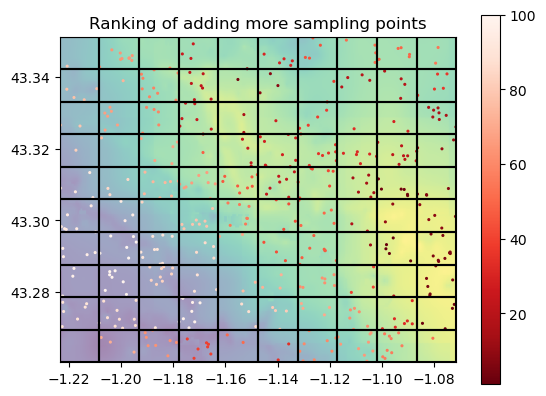

In [ ]:
import matplotlib.pyplot as plt
import rasterio

# Open the raster file
with rasterio.open(fname_raster) as src:
    # Get the bounds of the raster
    bounds = src.bounds
    # Read the first band
    raster_data = src.read(1)
    # Calculate the extent of the raster image
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Create a plot
fig, ax = plt.subplots()

# Display the raster image with the correct extent
plt.imshow(raster_data, extent=extent, cmap='viridis', alpha=0.5)  # Adjust alpha for transparency

# Plot the geodataframes on top of the raster image
gdf_samples_t0.plot(column='ranking', s=1.5, legend=True, colormap='Reds_r', ax=ax)
gdf_grid.boundary.plot(color='black', ax=ax)

# Add title to the plot
ax.set_title('Ranking of adding more sampling points')


Follow-up logic

1. use prior (t=0) with weight value 1 to randomly sample, 

2. Rank polygon based on states (loc_id)

3. Map rank of polygon to n_samples for t + 1 (Implement a total budget and give more samples to better ranked polygons)

4. Sample for T + 1 and add samples to gdf_samples_t0

5. Return to step 2

In [ ]:
# https://kapernikov.com/ipywidgets-with-matplotlib/